# 8. 비지도 학습
## 8.3 오토 인코더

In [1]:
import torch
import torchvision
from torchvision import transforms
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# CPU/GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{device} is available.')

cuda:0 is available.


In [3]:
dataset = torchvision.datasets.MNIST('./data/', download=True, train=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(dataset,batch_size=50,shuffle=True)

In [4]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
                        nn.Linear(784, 128), 
                        nn.ReLU(), 
                        nn.Linear(128, 32), 
                        nn.ReLU(), 
                        nn.Linear(32, 10), 
                        nn.ReLU())        
        self.decoder = nn.Sequential(
                        nn.Linear(10, 32),
                        nn.ReLU(),
                        nn.Linear(32, 128), 
                        nn.ReLU(), 
                        nn.Linear(128, 28*28) 
                        #nn.Sigmoid()
        )
    
    def forward(self, x):       
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [5]:
model = Autoencoder().to(device)

In [6]:
def normalize_output(img):
    img = (img - img.min())/(img.max()-img.min())
    return img

def check_plot():
    with torch.no_grad():
        for data in trainloader:

            inputs = data[0].to(device)
            outputs = model(inputs.view(-1,28*28))
            outputs = outputs.view(-1,1,28,28)
            
            input_samples = inputs.permute(0,2,3,1).cpu().numpy() # 원래 이미지
            reconstructed_samples = outputs.permute(0,2,3,1).cpu().numpy() # 생성 이미지
            
            break # 배치 하나만 받고 for문 종료

    #reconstructed_samples = normalize_output(reconstructed_samples) # 0~1사이로 변환
    #input_samples = normalize_output(input_samples) # 0~1사이로 변환

    columns = 10 # 시각화 전체 너비 
    rows = 5 # 시각화 전체 높이 

    fig=plt.figure(figsize=(columns, rows)) # figure 선언

    for i in range(1, columns*rows+1):
        img = input_samples[i-1]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img.squeeze())
        plt.axis('off')
    plt.show()
    plt.close()

    fig=plt.figure(figsize=(columns, rows))

    for i in range(1, columns*rows+1):
        img = reconstructed_samples[i-1]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img.squeeze())
        plt.axis('off')
    plt.show()

In [7]:
criterion = nn.MSELoss() # MSE 사용
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [8]:
for epoch in range(51):

    running_loss = 0.0
    for data in trainloader:

        inputs = data[0].to(device)
        optimizer.zero_grad()
        outputs = model(inputs.view(-1,28*28))
        outputs = outputs.view(-1,1,28,28)
        loss = criterion(inputs, outputs) # 라벨 대신 입력 이미지와 출력 이미지를 비교

        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    cost = running_loss / len(trainloader)        
    print('[%d] loss: %.3f' %(epoch + 1, cost))  


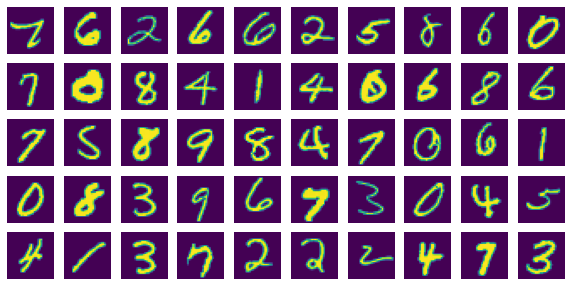

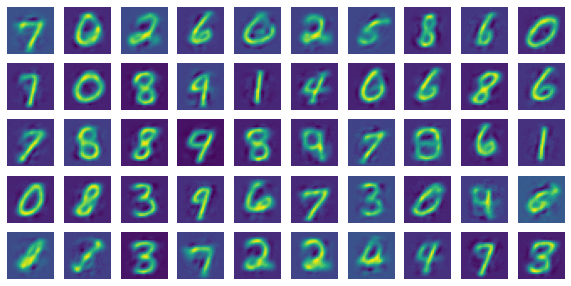

In [9]:
check_plot()